In [1]:
import os
# os.environ['TF_USE_LEGACY_KERAS'] = '1'
os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import keras
from keras import layers

import tensorflow as tf

In [2]:
!pip uninstall tensorflow
!pip install tensorflow==2.12.0

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.17.1
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [2]:
!unzip lr.zip

Archive:  lr.zip
   creating: lr/
  inflating: lr/8.png                
  inflating: __MACOSX/lr/._8.png     
  inflating: lr/9.png                
  inflating: __MACOSX/lr/._9.png     
  inflating: lr/10.png               
  inflating: __MACOSX/lr/._10.png    
  inflating: lr/4.png                
  inflating: __MACOSX/lr/._4.png     
  inflating: lr/5.png                
  inflating: __MACOSX/lr/._5.png     
  inflating: lr/7.png                
  inflating: __MACOSX/lr/._7.png     
  inflating: lr/6.png                
  inflating: __MACOSX/lr/._6.png     
  inflating: lr/2.png                
  inflating: __MACOSX/lr/._2.png     
  inflating: lr/3.png                
  inflating: __MACOSX/lr/._3.png     
  inflating: lr/1.png                
  inflating: __MACOSX/lr/._1.png     


In [3]:
!unzip hr.zip

Archive:  hr.zip
   creating: hr/
  inflating: hr/.DS_Store            
  inflating: __MACOSX/hr/._.DS_Store  
  inflating: hr/8.png                
  inflating: __MACOSX/hr/._8.png     
  inflating: hr/9.png                
  inflating: __MACOSX/hr/._9.png     
  inflating: hr/10.png               
  inflating: __MACOSX/hr/._10.png    
  inflating: hr/4.png                
  inflating: __MACOSX/hr/._4.png     
  inflating: hr/5.png                
  inflating: __MACOSX/hr/._5.png     
  inflating: hr/7.png                
  inflating: __MACOSX/hr/._7.png     
  inflating: hr/6.png                
  inflating: __MACOSX/hr/._6.png     
  inflating: hr/2.png                
  inflating: __MACOSX/hr/._2.png     
  inflating: hr/3.png                
  inflating: __MACOSX/hr/._3.png     
  inflating: hr/1.png                
  inflating: __MACOSX/hr/._1.png     


In [3]:
random.seed(10)

IMAGE_SIZE = 128
BATCH_SIZE = 2
MAX_TRAIN_IMAGES = 8


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    # in order to avoid `NONE` during shape inference
    low_image_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    enhanced_image_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("/content/lr/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("/content/hr/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("/content/lr/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("/content/hr/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("/content/lr/*"))
test_enhanced_images = sorted(glob("/content/hr/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset.element_spec)
print("Val Dataset:", val_dataset.element_spec)

Train Dataset: (TensorSpec(shape=(2, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 128, 128, 3), dtype=tf.float32, name=None))
Val Dataset: (TensorSpec(shape=(2, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 128, 128, 3), dtype=tf.float32, name=None))


In [4]:

def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
    )
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = layers.Reshape((1, 1, channels))(gap)
    compact_feature_representation = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature


In [5]:

class ChannelPooling(layers.Layer):
    def __init__(self, axis=-1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.axis = axis
        self.concat = layers.Concatenate(axis=self.axis)

    def call(self, inputs):
        average_pooling = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        max_pooling = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        return self.concat([average_pooling, max_pooling])

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})


def spatial_attention_block(input_tensor):
    compressed_feature_map = ChannelPooling(axis=-1)(input_tensor)
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(compressed_feature_map)
    feature_map = keras.activations.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = layers.Reshape((1, 1, channels))(average_pooling)
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])


In [6]:
# Recursive Residual Modules


def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau),
        level2_dau,
        up_sampling_module(level3_dau),
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])


In [7]:

def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=64)
# Cell 1: Load the Pretrained Model
from huggingface_hub import from_pretrained_keras

# Load the pretrained MIRNet model without compiling it
# Mirnet_model = from_pretrained_keras("keras-io/lowlight-enhance-mirnet", compile=False)

# Check the model summary to understand its architecture
# mirnet_model.summary()


Epoch 1/50
4/4 [==============================] - 147s 29s/step - loss: 0.1951 - peak_signal_noise_ratio: 62.0600 - val_loss: 0.1395 - val_peak_signal_noise_ratio: 64.8942 - lr: 1.0000e-04
Epoch 2/50
4/4 [==============================] - 108s 27s/step - loss: 0.1701 - peak_signal_noise_ratio: 62.0745 - val_loss: 0.1210 - val_peak_signal_noise_ratio: 65.3564 - lr: 1.0000e-04
Epoch 3/50
4/4 [==============================] - 110s 28s/step - loss: 0.1847 - peak_signal_noise_ratio: 61.1771 - val_loss: 0.1196 - val_peak_signal_noise_ratio: 65.0898 - lr: 1.0000e-04
Epoch 4/50
4/4 [==============================] - 105s 27s/step - loss: 0.1410 - peak_signal_noise_ratio: 63.5394 - val_loss: 0.1090 - val_peak_signal_noise_ratio: 65.6556 - lr: 1.0000e-04
Epoch 5/50
4/4 [==============================] - 106s 27s/step - loss: 0.1377 - peak_signal_noise_ratio: 64.3098 - val_loss: 0.1255 - val_peak_signal_noise_ratio: 64.8693 - lr: 1.0000e-04
Epoch 6/50
4/4 [==============================] - 109s 

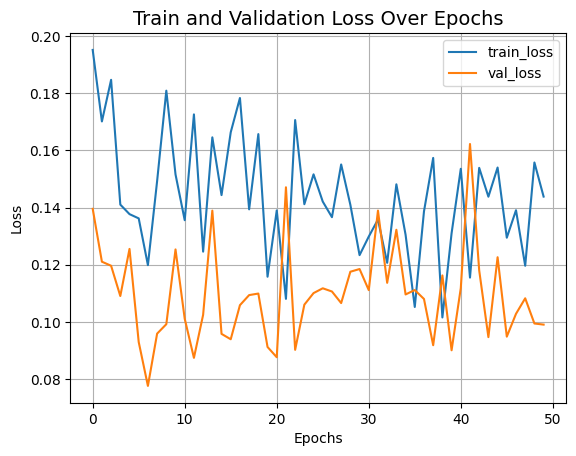

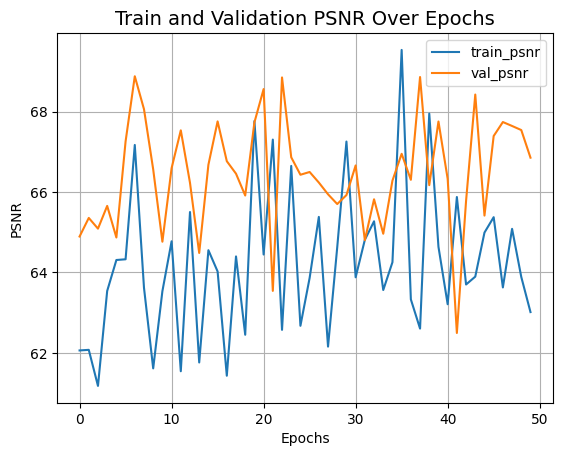

In [9]:

def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
Mirnet_model.compile(
    optimizer=optimizer,
    loss=charbonnier_loss,
    metrics=[peak_signal_noise_ratio],
)

history = Mirnet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)


def plot_history(value, name):
    plt.plot(history.history[value], label=f"train_{name.lower()}")
    plt.plot(history.history[f"val_{value}"], label=f"val_{name.lower()}")
    plt.xlabel("Epochs")
    plt.ylabel(name)
    plt.title(f"Train and Validation {name} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss", "Loss")
plot_history("peak_signal_noise_ratio", "PSNR")

In [10]:
# model.save('/content/trial_model.h5')
Mirnet_model.save('finetune_mirnet')


In [3]:
import keras
import tensorflow as tf

def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)

# Load the SavedModel
Mirnet_model = tf.keras.models.load_model('finetune_mirnet', custom_objects={'peak_signal_noise_ratio': peak_signal_noise_ratio, 'charbonnier_loss': charbonnier_loss})

# Verify the loaded model
# Mirnet_model.summary()

In [12]:
Mirnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   36928       ['conv2d[0][0]']                 
                                64)                                                           

In [16]:
# def plot_results(images, titles, figure_size=(12, 12)):
#     fig = plt.figure(figsize=figure_size)
#     for i in range(len(images)):
#         fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
#         _ = plt.imshow(images[i])
#         plt.axis("off")
#     plt.show()


# def infer(original_image):
#     image = keras.utils.img_to_array(original_image)
#     image = image.astype("float32") / 255.0
#     image = np.expand_dims(image, axis=0)
#     output = Mirnet_model.predict(image, verbose=0)
#     output_image = output[0] * 255.0
#     output_image = output_image.clip(0, 255)
#     output_image = output_image.reshape(
#         (np.shape(output_image)[0], np.shape(output_image)[1], 3)
#     )
#     output_image = Image.fromarray(np.uint8(output_image))
#     original_image = Image.fromarray(np.uint8(original_image))
#     return output_image

In [10]:
# def plot_result(image, title, figure_size=(6, 6)):
#     plt.figure(figsize=figure_size)
#     plt.imshow(image)
#     plt.axis("off")
#     plt.title(title)
#     plt.show()

# def infer(original_image):
#     image = keras.utils.img_to_array(original_image)
#     image = image.astype("float32") / 255.0
#     image = np.expand_dims(image, axis=0)  # Add batch dimension
#     output = Mirnet_model.predict(image, verbose=0)
#     output_image = output[0] * 255.0
#     output_image = output_image.clip(0, 255)
#     output_image = Image.fromarray(np.uint8(output_image))
#     return output_image


In [ ]:
# def process_single_image(low_light_image):
#     original_image = Image.open(low_light_image)
#     enhanced_image = infer(original_image)
#     plot_results(
#         [original_image, ImageOps.autocontrast(original_image), enhanced_image],
#         ["Original", "PIL Autocontrast", "MIRNet Enhanced"],
#         (20, 12),
#     )
#     return enhanced_image

# # Example usage
# low_light_image_path = "/content/00007.png"  # Replace with the actual image path
# enhanced_image = process_single_image(low_light_image_path)


In [25]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


In [19]:
from tensorflow.keras.preprocessing import image as keras_image
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model  # Ensure your model is properly loaded

# Load and process the low-light image
ll_image = Image.open('/content/1223313.jpg').convert('RGB')
# ll_image = ll_image.resize((256, 256), Image.NEAREST)
ll_image.show()  # Display the low-light image
# ll_image = Image.open(file).convert('RGB')

# Display the original low-light image
# ll_image.show()

# Resize the image to 256x256 using nearest-neighbor interpolation
low_light_img = ll_image.resize((256, 256), Image.NEAREST)

# Convert the PIL image to a NumPy array
image = img_to_array(low_light_img)

# Normalize the image to the range [0, 1]
image = image.astype('float32') / 255.0

# Expand dimensions to create a batch of size 1
image = np.expand_dims(image, axis=0)

# Predict the output using the model
output = Mirnet_model.predict(image)

# Scale the output back to the range [0, 255]
output_image = output[0] * 255.0
output_image = np.clip(output_image, 0, 255)

# Reshape the output image to its original dimensions
output_image = output_image.reshape((np.shape(output_image)[0], np.shape(output_image)[1], 3))

# Convert the image to uint32 and then to a PIL image
output_image = np.uint32(output_image)
result_image = Image.fromarray(output_image.astype('uint8'), 'RGB')

# Display the resulting image
result_image.show()

# Save the result image
result_image.save(f'/content/output_image3.jpg')

# Print a separator
print("*************")


1/1 [==============================] - 13s 13s/step
*************


In [12]:
# !zip -r finetune_mirnet.zip finetune_mirnet


  adding: finetune_mirnet/ (stored 0%)
  adding: finetune_mirnet/saved_model.pb (deflated 92%)
  adding: finetune_mirnet/keras_metadata.pb (deflated 96%)
  adding: finetune_mirnet/assets/ (stored 0%)
  adding: finetune_mirnet/variables/ (stored 0%)
  adding: finetune_mirnet/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: finetune_mirnet/variables/variables.index (deflated 82%)
  adding: finetune_mirnet/fingerprint.pb (stored 0%)


In [4]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

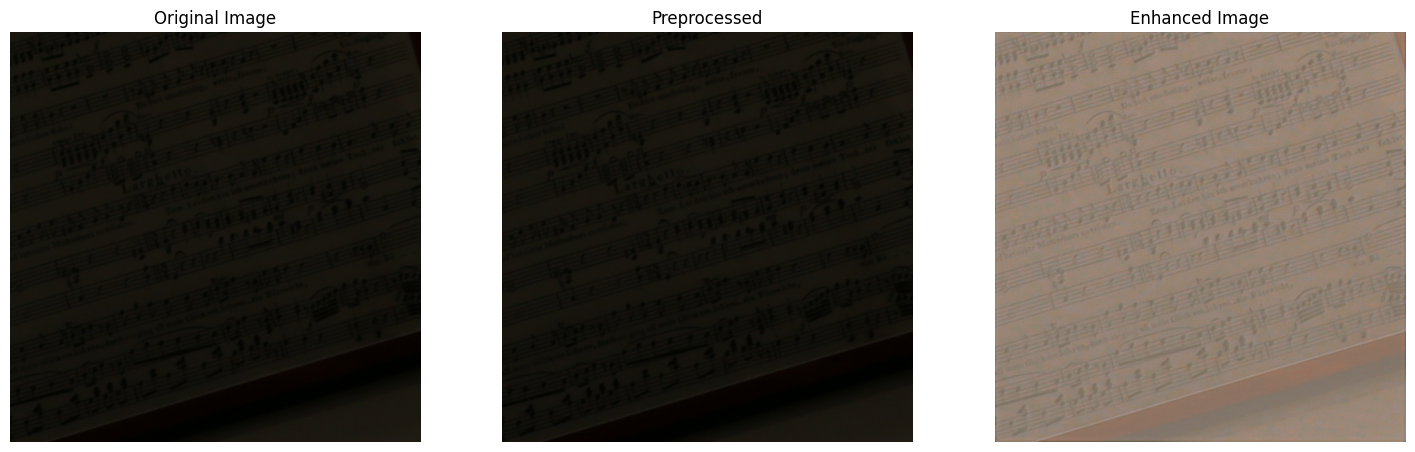

In [15]:
import tensorflow as tf
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# Constants
IMAGE_SIZE = 128

# Preprocessing functions
# def preprocess_single_image(image_path):
#     # Read and decode image
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_png(image, channels=3)
#     image = tf.cast(image, dtype=tf.float32) / 255.0  # Normalize to [0, 1]

#     # # Random crop
#     # image_shape = tf.shape(image)[:2]
#     # crop_w = tf.random.uniform(
#     #     shape=(), maxval=image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
#     # )
#     # crop_h = tf.random.uniform(
#     #     shape=(), maxval=image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
#     # )
#     # image_cropped = image[crop_h : crop_h + IMAGE_SIZE, crop_w : crop_w + IMAGE_SIZE]

#     # # Set shape explicitly for inference compatibility
#     # image_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
#     image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
#     return image

def preprocess_full_image(image_path, model):
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, dtype=tf.float32) / 255.0  # Normalize to [0, 1]



    # Get the model's required factor (e.g., 2^n for typical CNNs)
    factor = 2 ** 3  # Adjust based on your model's architecture
    height, width = tf.shape(image)[0], tf.shape(image)[1]

    # Calculate new dimensions divisible by the factor
    new_height = (height // factor) * factor
    new_width = (width // factor) * factor

    # Resize the image
    image = tf.image.resize_with_crop_or_pad(image, new_height, new_width)

    return image


# Inference function
def infer_single_image(image_path, model):
    # Preprocess the image
    preprocessed_image = preprocess_full_image(image_path,model)

    # Add batch dimension
    input_image = tf.expand_dims(preprocessed_image, axis=0)

    # Model prediction
    output = Mirnet_model.predict(input_image, verbose=0)

    # Post-process the output
    output_image = output[0] * 255.0  # Scale back to [0, 255]
    output_image = output_image.clip(0, 255)
    output_image = output_image.astype(np.uint8)


    return preprocessed_image.numpy(), output_image

# Visualization function
def visualize_results(original_image_path, preprocessed_image, enhanced_image):
    # Load original image for comparison
    original_image = Image.open(original_image_path)

    # Convert preprocessed and enhanced images to PIL format
    preprocessed_image_pil = Image.fromarray((preprocessed_image * 255).astype(np.uint8))
    enhanced_image_pil = Image.fromarray(enhanced_image)
    enhanced_image_pil.save(f'/content/output_image7.png')
    # Plot the results
    plot_results(
        [original_image, preprocessed_image_pil, enhanced_image_pil],
        ["Original Image", "Preprocessed", "Enhanced Image"],
        figure_size=(18, 6)
    )

# Example usage
test_image_path = "/content/7.png"  # Replace with your test image path
preprocessed_image, enhanced_image = infer_single_image(test_image_path, Mirnet_model)
visualize_results(test_image_path, preprocessed_image, enhanced_image)


In [21]:
def preprocess_large_image(image_path, model, max_dimension=1024):
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, dtype=tf.float32) / 255.0  # Normalize to [0, 1]

    # Get original dimensions
    original_height = tf.cast(tf.shape(image)[0], tf.int32)
    original_width = tf.cast(tf.shape(image)[1], tf.int32)

    # Scale down the image if it exceeds max_dimension
    scale_factor = tf.minimum(
        max_dimension / tf.cast(original_height, tf.float32),
        max_dimension / tf.cast(original_width, tf.float32)
    )
    new_height = tf.cast(tf.cast(original_height, tf.float32) * scale_factor, tf.int32)
    new_width = tf.cast(tf.cast(original_width, tf.float32) * scale_factor, tf.int32)

    # Resize image
    resized_image = tf.image.resize(image, [new_height, new_width])

    # Pad to make dimensions compatible with the model
    factor = 2 ** 3  # For divisibility by 8
    padded_height = (new_height // factor) * factor
    padded_width = (new_width // factor) * factor
    resized_padded_image = tf.image.resize_with_crop_or_pad(resized_image, padded_height, padded_width)

    return resized_padded_image, (original_height, original_width), (new_height, new_width)


In [22]:
def infer_large_image(image_path, model):
    # Preprocess the image
    preprocessed_image, original_shape, resized_shape = preprocess_large_image(image_path, model)

    # Add batch dimension
    input_image = tf.expand_dims(preprocessed_image, axis=0)

    # Model prediction
    output = model.predict(input_image, verbose=0)

    # Remove batch dimension and scale back to [0, 255]
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255).astype(np.uint8)

    # Resize back to the original dimensions
    print(output_image.shape)
    # output_image = tf.image.resize(output_image, original_shape[:2], method="bicubic").numpy().astype(np.uint8)

    return output_image


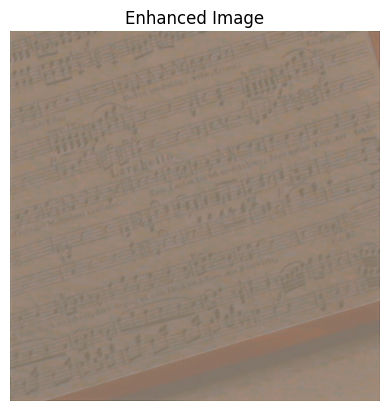

In [26]:
test_image_path = "/content/7.png"
enhanced_image = infer_large_image(test_image_path, Mirnet_model)

# Display the result
plt.imshow(enhanced_image)
plt.axis("off")
plt.title("Enhanced Image")
plt.show()


In [27]:

enhanced_image = Image.fromarray(enhanced_image)
enhanced_image.save(f'/content/output_image8.jpg')

In [ ]:
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input
# import numpy as np
# from PIL import Image
# from tensorflow.keras.utils import img_to_array # Import img_to_array from tf.keras.utils or keras.utils

# # Load and resize the image to (256, 256, 3)
# # img = image.load_img('/content/00643-5.0.png', target_size=(256, 256))
# # img_array = image.img_to_array(img)  # Convert image to numpy array
# # img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
# # img_array = preprocess_input(img_array)  # Preprocess for model input (if needed)


# img = image.load_img('/content/00007.png', target_size=(256, 256)).convert('RGB')
# low_light_img = img.resize((256,256),Image.NEAREST)
# image = keras.preprocessing.image.img_to_array(low_light_img)
# image = image.astype('float32') / 255.0
# image = np.expand_dims(image, axis = 0)
# output = Mirnet_model.predict(image)
# output_image = output[0] * 255.0
# output_image = output_image.clip(0,255)
# output_image = output_image.reshape((np.shape(output_image)[0],np.shape(output_image)[1],3))
# output_image = np.uint32(output_image)
# result_image=Image.fromarray(output_image.astype('uint8'),'RGB')
# display(result_image)

In [3]:
!unzip finetune_mirnet.zip

Archive:  finetune_mirnet.zip
   creating: finetune_mirnet/
  inflating: finetune_mirnet/saved_model.pb  
  inflating: finetune_mirnet/keras_metadata.pb  
   creating: finetune_mirnet/assets/
   creating: finetune_mirnet/variables/
  inflating: finetune_mirnet/variables/variables.data-00000-of-00001  
  inflating: finetune_mirnet/variables/variables.index  
 extracting: finetune_mirnet/fingerprint.pb  
